In [1]:
# pip install pyarrow graphviz

In [2]:
import graphviz
from pgmpy.base import DAG
from networkx import is_d_separator

import pandas as pd
from pathlib import Path
import pyarrow.parquet as pq

pd.set_option('display.max_columns', None)

In [3]:
cwd = Path.cwd() / 'hoopR'

team_path = cwd / 'team_box_2026.parquet'
player_path = cwd / 'player_box_2026.parquet'

schedule_path = cwd / 'mbb_schedule_2026.parquet'
play_by_play_path = cwd / 'play_by_play_2026.parquet'

In [4]:
def read_hoopR_parquets(path_list):
    return [pq.read_table(p).to_pandas() for p in path_list]

team_df, player_df, sched_df, pbp_df = read_hoopR_parquets([team_path, player_path, schedule_path, play_by_play_path])

In [5]:
team_cols = ['game_id', 'team_id', 'opponent_team_id', 'fouls']
switch_cols = {'team_id': 'opponent_team_id', 'opponent_team_id': 'team_id', 'fouls': 'opponent_fouls'}

team_df = team_df[team_cols].rename(columns=switch_cols)
team_df.head()

,game_id,opponent_team_id,team_id,opponent_fouls
0,401829220,2539,2541,14
1,401829220,2541,2539,20
2,401825477,26,2483,13
3,401825477,2483,26,17
4,401830830,36,21,13


In [6]:
player_cols = ['game_id', 'team_id', 'opponent_team_id', 'home_away', 'athlete_id', 'athlete_display_name', 'athlete_position_name', 'team_display_name', 'minutes', 'free_throws_attempted', 'free_throws_made']

player_df = player_df[player_cols]
player_df.head()

,game_id,team_id,opponent_team_id,home_away,athlete_id,athlete_display_name,athlete_position_name,team_display_name,minutes,free_throws_attempted,free_throws_made
0,401829220,2539,2541,away,5176426.0,Junjie Wang,Forward,San Francisco Dons,25.0,2.0,2.0
1,401829220,2539,2541,away,5174624.0,David Fuchs,Forward,San Francisco Dons,16.0,1.0,1.0
2,401829220,2539,2541,away,5176425.0,Ryan Beasley,Guard,San Francisco Dons,31.0,4.0,3.0
3,401829220,2539,2541,away,5101799.0,Legend Smiley,Guard,San Francisco Dons,17.0,0.0,0.0
4,401829220,2539,2541,away,5037875.0,Tyrone Riley IV,Guard,San Francisco Dons,26.0,0.0,0.0


In [7]:
df = pd.merge(team_df, player_df, how='inner', on=['game_id', 'opponent_team_id', 'team_id'])
df['home_away'] = [0 if record == 'away' else 1 for record in df['home_away']] # 1 if home, 0 if away. This will be switched below!

# You don't want to know how long I banged my head on my desk not realizing I was dividing by 0 without this line of code:
df = df[df['free_throws_attempted'] > 0]

df['free_throw_pct'] = df['free_throws_made'] / df['free_throws_attempted']
df.dropna(inplace=True)
df.head()

,game_id,opponent_team_id,team_id,opponent_fouls,home_away,athlete_id,athlete_display_name,athlete_position_name,team_display_name,minutes,free_throws_attempted,free_throws_made,free_throw_pct
0,401829220,2539,2541,14,1,5241069.0,Elijah Mahi,Forward,Santa Clara Broncos,30.0,2.0,2.0,1.000000
1,401829220,2539,2541,14,1,5176361.0,Bukky Oboye,Center,Santa Clara Broncos,14.0,3.0,2.0,0.666667
2,401829220,2539,2541,14,1,5176359.0,Christian Hammond,Guard,Santa Clara Broncos,31.0,2.0,1.0,0.500000
5,401829220,2539,2541,14,1,5149115.0,Allen Graves,Forward,Santa Clara Broncos,25.0,4.0,3.0,0.750000
9,401829220,2539,2541,14,1,5147928.0,Thierry Darlan,Guard,Santa Clara Broncos,12.0,2.0,2.0,1.000000


Count HOME games: 23993
Count AWAY games: 21331


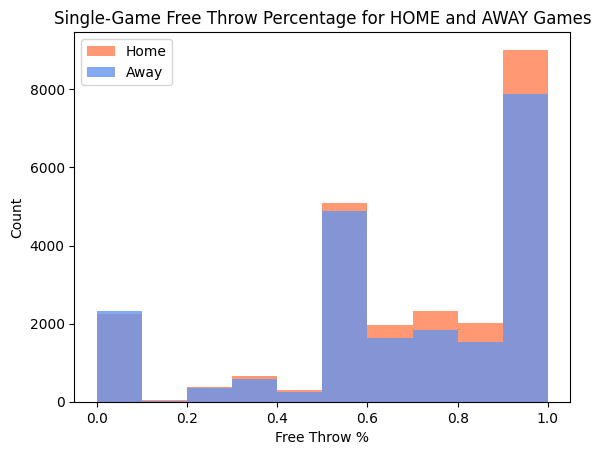

In [8]:
import matplotlib.pyplot as plt
home = df[df['home_away'] == 1]
away = df[df['home_away'] == 0]

print(f"Count HOME games: {len(home)}")
print(f"Count AWAY games: {len(away)}")

plt.hist(home['free_throw_pct'], alpha=0.8, color='coral', label='Home')
plt.hist(away['free_throw_pct'], alpha=0.8, color='cornflowerblue', label='Away')

plt.title('Single-Game Free Throw Percentage for HOME and AWAY Games')
plt.xlabel('Free Throw %')
plt.ylabel('Count')
plt.legend()
plt.show()

In [9]:
df['home_away'] = [int(not record) for record in df['home_away']] # Now, we want to make playing an away game the TREATMENT.

In [10]:
graphviz_graph = """
digraph {
    graph [rankdir=LR, splines=curved];
    node [shape=box, style="filled,rounded", fillcolor="#f0f0f0"];

    "Home/Away" -> FreeThrows_Made;
    MinutesPlayed -> FreeThrow_Attempts -> "FreeThrow_%";
    OpponentFouls -> FreeThrow_Attempts -> FreeThrows_Made -> "FreeThrow_%";
}
"""

dot = graphviz.Source(graphviz_graph)
dot.render('graphviz_graph', view=True, format='png')

'graphviz_graph.png'

<img src="graphviz_graph.png" width="700" />

In [11]:
dag = DAG(
    [('minutes','free_throws_attempted'),
     ('opponent_fouls','free_throws_attempted'),
     ('home_away','free_throws_made'),
     ('free_throws_attempted','free_throws_made'),
     ('free_throws_attempted','free_throw_pct'),
     ('free_throws_made','free_throw_pct')
    ]
)

In [12]:
dseps = dag.get_independencies()
dseps

(opponent_fouls ⟂ home_away)
(free_throw_pct ⟂ home_away | free_throws_attempted, free_throws_made)
(free_throw_pct ⟂ minutes | free_throws_attempted)
(home_away ⟂ free_throws_attempted)
(opponent_fouls ⟂ free_throw_pct | free_throws_attempted)
(minutes ⟂ home_away)
(opponent_fouls ⟂ free_throws_made | free_throws_attempted)
(opponent_fouls ⟂ minutes)
(minutes ⟂ free_throws_made | free_throws_attempted)

In [13]:
from pgmpy.estimators.CITests import chi_square
from pgmpy.independencies import IndependenceAssertion

def test_dsep(dsep):
    test_outputs = []
    for X in list(dsep.get_assertion()[0]):
        for Y in list(dsep.get_assertion()[1]):
            Z = list(dsep.get_assertion()[2])
            test_result = chi_square(
                X=X, Y=Y, Z=Z,
                data=df,
                boolean=True,
                significance_level=0.05
            )
            assertion = IndependenceAssertion(X, Y, Z)
            test_outputs.append((assertion, test_result))
    return test_outputs

c:\Users\amgal\Documents\Data Science\MSDS 452-DL\dag_nabbit\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
results = [test_dsep(dsep) for dsep in dseps.get_assertions()]
results = dict([item for sublist in results for item in sublist])
results

{(opponent_fouls ⟂ home_away): np.False_,
 (free_throw_pct ⟂ home_away | free_throws_attempted, free_throws_made): np.False_,
 (free_throw_pct ⟂ minutes | free_throws_attempted): np.False_,
 (home_away ⟂ free_throws_attempted): np.False_,
 (opponent_fouls ⟂ free_throw_pct | free_throws_attempted): np.True_,
 (minutes ⟂ home_away): np.False_,
 (opponent_fouls ⟂ free_throws_made | free_throws_attempted): np.True_,
 (opponent_fouls ⟂ minutes): np.False_,
 (minutes ⟂ free_throws_made | free_throws_attempted): np.False_}

In [15]:
num_pass = sum(results.values())
num_dseps = len(dseps.independencies)
num_fail = num_dseps - num_pass
print(num_fail / num_dseps)


0.7777777777777778


# Using DoWhy

In [16]:
# pip install dowhy econml

In [17]:
import dowhy
import econml

import logging
import warnings
from sklearn.exceptions import DataConversionWarning

logging.getLogger("dowhy").setLevel(logging.WARNING)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings('ignore')

In [18]:
graph = """
digraph {
    home_away -> free_throws_made 
    minutes -> free_throws_attempted -> free_throw_pct
    opponent_fouls  -> free_throws_attempted -> free_throws_made  -> free_throw_pct
}
"""

In [19]:
model = dowhy.CausalModel(
        data=df,
        treatment="home_away",
        outcome="free_throw_pct",
        graph=graph
        )

ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...


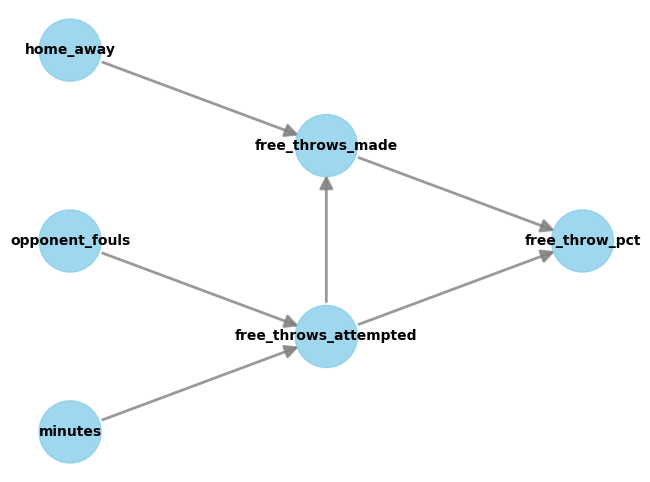

In [20]:
model.view_model()

In [21]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                         
────────────(E[free_throw_pct])
d[home_away]                   
Estimand assumption 1, Unconfoundedness: If U→{home_away} and U→free_throw_pct then P(free_throw_pct|home_away,,U) = P(free_throw_pct|home_away,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

### Estimand : 4
Estimand name: general_adjustment
Estimand expression:
     d                         
────────────(E[free_throw_pct])
d[home_away]                   
Estimand assumption 1, Unconfoundedness: If U→{home_away} and U→free_throw_pct then P(free_throw_pct|home_away,,U) = P(free_throw_pct|home_away,)



In [22]:
linear_estimate = model.estimate_effect(identified_estimand,
                                        method_name="backdoor.linear_regression",
                                        control_value=0,
                                        treatment_value=1)
print(linear_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                         
────────────(E[free_throw_pct])
d[home_away]                   
Estimand assumption 1, Unconfoundedness: If U→{home_away} and U→free_throw_pct then P(free_throw_pct|home_away,,U) = P(free_throw_pct|home_away,)

## Realized estimand
b: free_throw_pct~home_away+home_away*opponent_fouls+home_away*free_throws_attempted+home_away*minutes
Target units: 

## Estimate
Mean value: -0.01934448591508109
### Conditional Estimates
__categorical__opponent_fouls  __categorical__free_throws_attempted  __categorical__minutes
(2.999, 15.0]                  (0.999, 2.0]                          (-0.001, 16.0]           -0.099018
                                                                     (16.0, 22.0]             -0.060177
                                                                     (22.0, 27.0]        

In [23]:
print(linear_estimate.value)

-0.01934448591508109


In [24]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from econml.inference import BootstrapInference

dml_estimate = model.estimate_effect(identified_estimand,
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = "ate",
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final": LassoCV(fit_intercept=False),
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                                                            }
                                              })
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                         
────────────(E[free_throw_pct])
d[home_away]                   
Estimand assumption 1, Unconfoundedness: If U→{home_away} and U→free_throw_pct then P(free_throw_pct|home_away,,U) = P(free_throw_pct|home_away,)

## Realized estimand
b: free_throw_pct~home_away | opponent_fouls,free_throws_attempted,minutes
Target units: ate

## Estimate
Mean value: -0.02060074690654105
Effect estimates: [[-0.02511834]
 [-0.02653196]
 [-0.02492501]
 ...
 [-0.02607098]
 [-0.02587764]
 [-0.02632461]]
95.0% confidence interval: [[[-0.03508611 -0.04009654 -0.03474656 ... -0.03682849 -0.03665801
   -0.03885809]]

 [[-0.01555088 -0.0146736  -0.01489388 ... -0.01762101 -0.01762292
   -0.01400889]]]



In [25]:
dml_estimate.value

In [26]:
print(min(dml_estimate.cate_estimates))
print(max(dml_estimate.cate_estimates))

[-0.03712213]
[0.03174481]


In [27]:
res_placebo=model.refute_estimate(identified_estimand, linear_estimate, method_name="placebo_treatment_refuter", show_progress_bar=True, placebo_type="permute")
print(res_placebo)

Refuting Estimates: 100%|██████████| 100/100 [01:17<00:00,  1.29it/s]

Refute: Use a Placebo Treatment
Estimated effect:-0.01934448591508109
New effect:-0.0010023932315556428
p value:0.72



In [28]:
res_random=model.refute_estimate(identified_estimand, linear_estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:-0.01934448591508109
New effect:-0.01934492684281513
p value:0.94

